
# Problem Set 5: Trees, Forests, and Fairness in ML


Your mission for this problem set is to use your knowledge of tree-based methods and supervised learning to -- among other things! -- explore issues of fairness in machine learning (ML). Unlike in previous psets, where we were implementing algorithms from scratch, this pset will rely more heavily on sklearn. Unless explicitly noted otherwise, you are allowed (encouraged!) to make good use of this wonderful library. 

This problem set will also rely on the resources provided by the [folktables](https://github.com/socialfoundations/folktables?tab=readme-ov-file) project. Before getting started, take some time to understand what folktables is about and how it can be used to benchmark ML algorithms in social science. If you don't understand the basics, this pset will be very challenging!!

Some resources you might find useful:

[Folktables paper](https://arxiv.org/abs/2108.04884)

[Folktables video](youtube.com/watch?v=KP7DhM_ahHI)

[PUMS_Data_Dictionary_2018](https://www2.census.gov/programssurveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2018.pdf)

[Fairness in ML](https://fairmlbook.org/classification.html)

--- 
# Part 0

### Question 1 - upload your ipynb to bcourses

### Question 2 - upload your pdf to bcourses


### Question 3 - please provide a summary of any resources consulted, and people with whom you worked in the completion of the problem set.

Highlight any specific LLM prompts/resources used at the point of use.

## Part I: Setup of prediction task

### Question 4: Define the income prediction task

For this first question we are providing the code. Run it to download the data you'll be using throughout this problem set. 

Begin by answering the following questions:

* Where do the data come from?
* What is the sample?
* What are we trying to predict?
* What are the features that we will be using?
* What is the "group" feature?


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folktables
import seaborn as sns

In [4]:
from folktables import ACSDataSource, generate_categories

def adult_filter(data):
    """Mimic the filters in place for Adult data.

    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    return df

ACSIncome = folktables.BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'POBP',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='RAC1P',
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)
features, target, group = ACSIncome.df_to_pandas(acs_data)

feature_names = ACSIncome.features
target_name = ACSIncome.target
group_name = ACSIncome.group

The data is sourced from the American Community Survey (ACS), an annual mandatory survey that gathers information about individual demographics, employment, income and housing characteristics. The specific subset used is the Public Use Microdata Sample (PUMS), which are the responses to the survey questions from a subset of the total respondents to the ACS.

In this specific case we are initialising the ACSIncome prediction task, which predicts whether a respondent's yearly income is above $50000. The features being used are: Age, Class of worker, Educational attainment, Marital status, Place of Birth, Relationshp (to respondent), Usual hours wokred per week past 12 months, Sex and Racial Group. 

The group feature is the feature on which we will group the data and compare the target outcome. In this case we will compare the prediction of income above $50000 for each racial group identified in the 'RAC1P' feature. This will allow us to evaluate on how the model violates fairness metrics such as equality of opportunity. 

### Question 5: Split into train and test

Split your data into 80%-20% train and test splits. 

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, target, group, test_size=0.2, random_state=0)

### Question 6: Data Cleaning

Remember to identify which features are best represented as numerical data types, and which ones are best represented as categorical data types. 
- Set each feature to its desired data type in both train and test splits. Make sure that the target variable in both splits is numeric before moving ahead.


In [45]:
# Set target variables to numeric
y_train['PINCP'] = pd.to_numeric(y_train['PINCP'])
y_test['PINCP'] = pd.to_numeric(y_test['PINCP'])

cat_cols = features.columns.to_list()
cat_cols.remove('AGEP')
cat_cols.remove('WKHP')

X_train[cat_cols] = X_train[cat_cols].astype('category')
X_test[cat_cols] = X_test[cat_cols].astype('category')

### Question 7: Entropy and Information Gain

As we discussed in lecture, decision trees (and their variants) recursively split your dataset into smaller and smaller samples. Let's review how these splits are placed!

For this exercise, consider a really simple decision tree, with only 1 feature: WKHP. Given our income prediction task (defined above), your task is to determine whether it would be better to split this feature at WKHP = 40, or WKHP = 50. 
Your tasks:
- Complete the function *weighted_entropy*. The function takes as input a feature, a split point for the feature, and the target. The function returns the entropy (as defined and discussed in the lectures) for that particular split. 
- Using this function, calculate and report the entropy gain from 1) placing a split at WKHP = 40 and 2) placing a split at WKHP = 50. 
- State your conclusion: is it better (in terms of information gain) to split the feature WKHP at the value 40 or the value 50?

Hint: review pages 25 - 30 in Lecture 12: Decision Trees 

In [ ]:
def entropy(target):
    p1 = np.mean(target)
    p0 = 1 - p1

    return - (p1 * np.log2(p1) + p0 * np.log2(p0))

def weighted_entropy(x, y, split_point):
    """
    x: a column vector of dimensions N X 1 (the feature)
    y: a column vector of dimensions N x 1 (the target variable)
    split_point: an integer in the range [min(x), max(x)], which indicates where to split the feature x. 
    """
    n_values = len(y)

    left_mask = x <= split_point
    right_mask = x > split_point

    left_y = y[left_mask]
    right_y = y[right_mask]

    wt_entropy = (len(left_y)/n_values)* entropy(left_y) + (len(right_y)/n_values)* entropy(right_y)

    return wt_entropy

x = X_train['WKHP']
y = y_train['PINCP']

ent = entropy(y_train)
ent_40 = weighted_entropy(x, y, 40)
ent_50 = weighted_entropy(x, y, 50)

print(f"Entropy at parent node is {ent:.3f}")
print(f"weighted entropy at split point = 40 is {ent_40:.3f}")
print(f"weighted entropy at split point = 50 is {ent_50:.3f}")
print(f"Information gain for 40 = {(ent - ent_40):.3f} for 50 = {(ent - ent_50):.3f}" )

Entropy at parent node is 0.977
weighted entropy at split point = 40 is 0.923
weighted entropy at split point = 50 is 0.962
Information gain for 40 = 0.054 for 50 = 0.015


Splitting at WKHP = 40 is better as it has a higher information gain at 0.054 compared to 0.015 for the split at 50.

## Part II: ML pipeline for a Classification Tree

Next, you'll build an ML pipeline using sklearn. Take some time to familiarize yourself with [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) before proceeding.

### Question 8: Pre-processing of features

The first step of the pipeline will standardize the numeric features and one-hot encode the categorical features. Write the code for this preprocessing step below. 

**Hint**: Take a look at sklearn's ColumnTransformer, OneHotEncoder and StandardScaler for this task. 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_cols = X_train.select_dtypes(include = ['category']).columns
num_cols = X_train.select_dtypes(include = ['float64']).columns
ct = ColumnTransformer([('Standardize', StandardScaler(), num_cols),
                        ('One-hot encode', OneHotEncoder(),cat_cols)], )

### Question 9: Use your pre-processed data to fit a basic DecisionTreeClassifier

Now, bring together the pre-processing step with a Decision Tree Classifier in a pipeline. For now, use the default values; we'll take care of hyperparameter optimization later. 
- Fit the pipeline on the training data. 
- How deep is the resulting tree? How many leafs are in the tree? 
- Print the 10 variables with highest feature importance and tell us what those importances mean in plain English. 
- Plot the top 3 levels of the fitted decision tree. Make sure that the nodes are appropriately labeled. 

Final tree has depth 87 and 37845

Top 10 Features by Importance:
        Feature  Importance
0          AGEP    0.233451
1          WKHP    0.201175
182  POBP_303.0    0.048572
30    SCHL_21.0    0.031870
31    SCHL_22.0    0.027139
25    SCHL_16.0    0.024585
32    SCHL_23.0    0.018331
2       COW_1.0    0.016560
43     POBP_6.0    0.016169
258    RELP_0.0    0.016166


[Text(0.5, 0.875, 'WKHP <= -0.181\ngini = 0.484\nsamples = 156532\nvalue = [92232, 64300]\nclass = > $50000'),
 Text(0.25, 0.625, 'AGEP <= 0.924\ngini = 0.242\nsamples = 44240\nvalue = [38000, 6240]\nclass = > $50000'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'AGEP <= -0.755\ngini = 0.149\nsamples = 33319\nvalue = [30614, 2705]\nclass = > $50000'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'SCHL_22.0 <= 0.5\ngini = 0.438\nsamples = 10921\nvalue = [7386, 3535]\nclass = > $50000'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'AGEP <= -0.957\ngini = 0.499\nsamples = 112292\nvalue = [54232.0, 58060.0]\nclass = < $5000'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'SCHL_21.0 <= 0.5\ngini = 0.344\nsamples = 17642\nvalue = [13749, 3893]\nclass = > $50000'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'POBP_303.0 <=

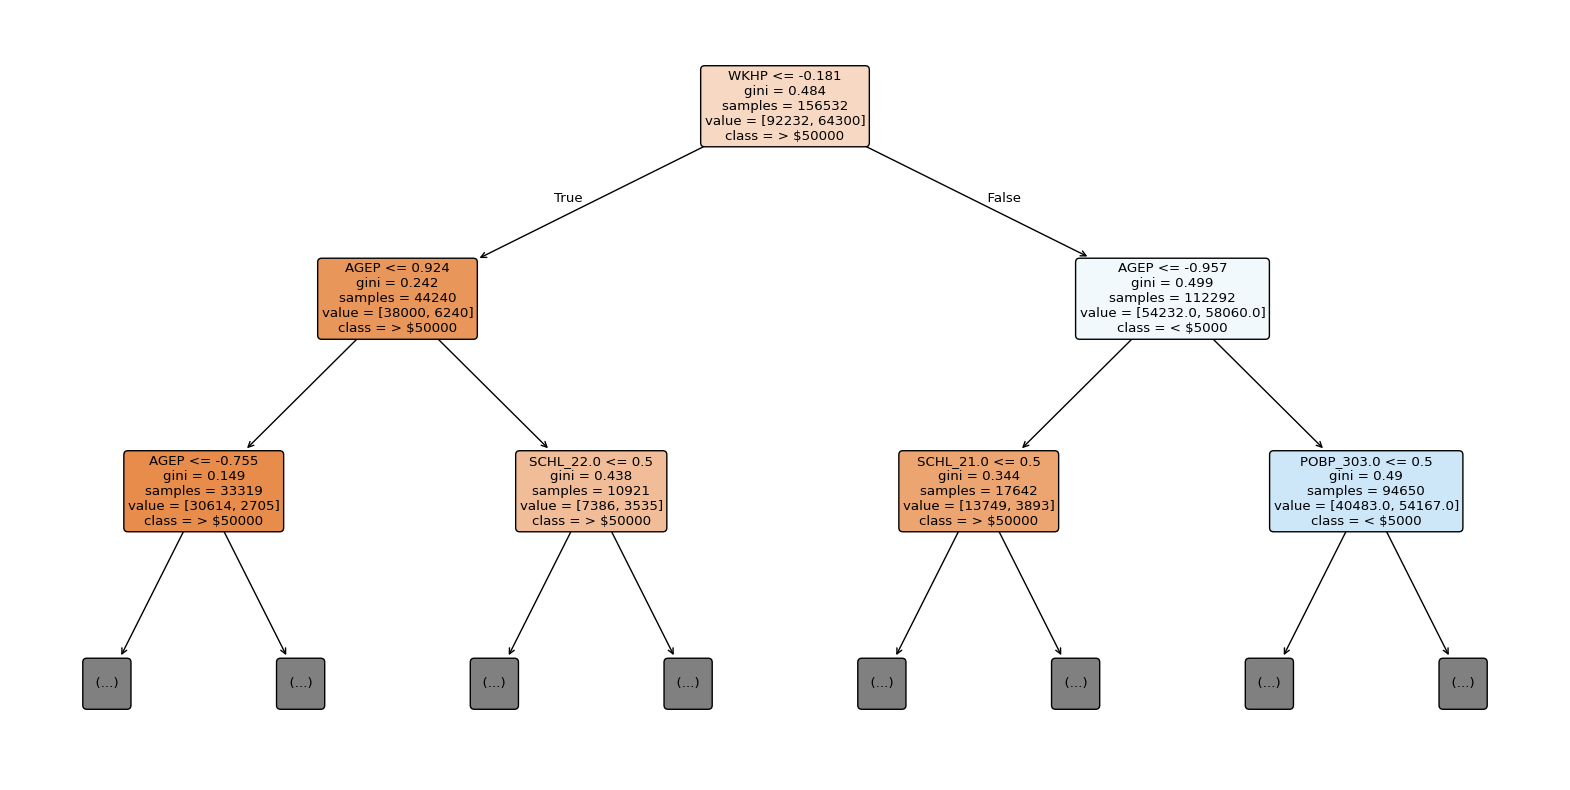

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import plot_tree

# Create pipeline with 2 steps
pipe = Pipeline([('preprocessing', ct), ('decision_tree', DecisionTreeClassifier())])

# Fit pipeline onto data
pipe.fit(X_train,y_train)

# Extract final tree
final_tree = pipe.named_steps['decision_tree']

# Extract information about tree
print(f"Final tree has depth {final_tree.get_depth()} and {final_tree.get_n_leaves()} leaves")

# Extract features 
feature_imp = final_tree.feature_importances_

col_names = num_cols.tolist() + list(pipe.named_steps['preprocessing'].named_transformers_['One-hot encode'].get_feature_names_out())

feature_importance_df = pd.DataFrame({
    'Feature': col_names,
    'Importance': feature_imp
})

feature_importance_df.sort_values(by='Importance', ascending=False, inplace = True)
print("\nTop 10 Features by Importance:")
print(feature_importance_df.head(10))


# Plot tree
plt.figure(figsize = (20,10))
plot_tree(final_tree, max_depth = 2, filled = True, feature_names = col_names,class_names= ['> $50000', '< $5000'], rounded = True )

The resulting tree using the default hyperparameters and no max depth depth 87 and 37845 leaves. 

The top 10 important features are as following:

1) AGEP: Multiple splits based on a value of AGE contribute 23.3% of the reduction in impurity
2) WKHP: Splitting based on the hours worked per week contributes 20.1% of the reduction in impurity
3) POBP_303.0: Splits based on whether individuals were born in Mexico had a 4.86% reduction in imprity
4) SCHL_21.0: Splits based on whether individuals had a bachelor's degree had a 3.19% reduction in impurity 
5) SCHL_22.0: Splits based on whether individuals had a master's degree had a 2.71% reduction in impurity   
6) SCHL_16.0: Splits based on whether individuals finished high school had a 2.45% reduction in impurity     
7) SCHL_23.0: Splits based on whether individuals had a professional degree beyond bachelor's had a 1.83% reduction in impurity.
8) COW_1.0: Splits based on whether individuals were an employee in a private company had a 1.65% reduction in impurity.
9) POBP_6.0: Splits based on whether individuals were born in California had a 1.61% reduction in imprity  
10) RELP_0.0 Splits based on whether the individuals was the reference person in the survey had a 1.61% reduction in imprity.

### Question 10: Performance Metrics

Let's evaluate the performance of your classifier. Generate predictions from your fitted model, and calculate the following metrics (on the training dataset):
- accuracy
- precision
- recall
- f1-score

 **Do not use any pre-packaged or canned functions from sklearn to calculate these metrics.** Rather, implement the necessary code to calculate these from scratch. You can continue using DecisionTreeClassifier to generate predictions etc. 


In [65]:
y_pred = pipe.predict(X_test)

def performance_metrics(y_pred, y):
    acc = np.mean(y_pred == y)
    prec = np.sum((y_pred == 1) & (y == 1))/ np.sum(y_pred == 1)
    rec = np.sum((y_pred == 1) & (y == 1))/ np.sum(y == 1)
    f1 = 2*(prec*rec)/(prec + rec) if prec + rec != 0 else 0

    print(f"Accuracy is {acc:.3f}, Precision is {prec:.3f}, Recall is {rec:.3f}, f1 score is {f1:.3f}")

performance_metrics(y_pred, y_test['PINCP'])

Accuracy is 0.741, Precision is 0.687, Recall is 0.674, f1 score is 0.680


### Question 11: Estimate AUC using K-Fold CV

Calculate the 5-fold cross-validated AUC-ROC for this simple tree pipeline.
- Report the score for each fold as well as the average across all folds. 

**Hint 1**: sklearn.model_selection.cross_val_score is your friend. Setting the verbose option to 3 is useful. 

In [66]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(pipe, X_train, y_train, cv = 5, scoring = 'roc_auc', verbose = 3)

print(score)

c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\utils\_response.py", line 214, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^

[CV] END .................................. score: (test=nan) total time=  27.0s
[CV] END ................................ score: (test=0.739) total time=  26.6s


c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\utils\_response.py", line 214, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^

[CV] END .................................. score: (test=nan) total time=  24.5s


c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\utils\_response.py", line 214, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^

[CV] END .................................. score: (test=nan) total time=  29.8s
[CV] END .................................. score: (test=nan) total time=  33.5s
[       nan 0.73854456        nan        nan        nan]


c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\PB\Documents\GitHub\Info251\.conda\Lib\site-packages\sklearn\utils\_response.py", line 214, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^

### Question 12: Estimating AUC using nested CV [extra-credit]

Let's try to improve on the results of the decision tree by tweaking its hyperparameters. Since you already are an expert using nested CV, this is going to be a walk in the park! Compute the nested cv AUC-ROC of a decision tree pipeline. Use 5 folds for the inner loop and 3 folds for the outer loop. Include different values for "max_depth", "max_features" and "max_leave_nodes" in your hyperparameter grid. 
 - Ensure that you print out the inner and outer fold scores for all combinations of hyperparams.
 - Report the AUC-ROC of a decision tree pipeline (average over outer fold scores)
 - Report the best hyperparameters used in each outer fold.
 - Interpret your results:
   - Are they stable?
   - To what extent do you think specific hyperparameters might lead to overfitting?
   - How is run-time impacted by your choice of hyperparameters?
   - Is hyperparameter optimization worth the trouble?

**Hint 1**: The pipeline remains the same. You can access the list of all the hyperparams in your pipeline with pipeline.get_params_keys(). Notice the naming convention.

**Hint 2**: [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) are your friends-- especially if you run them with verbose = 3.

**Hint 3**: This gets computationally expensive quickly. Be intelligent about the hyperparameter values you include in the grid and the number of outer and inner folds you use (we use 5 inner folds and 3 outer folds).

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

# your code here    


## Part III: ML pipeline for a random forest

### Question 13: Bare bones random forest
Just as you did for the classification tree, start by training a bare bones random forest using your training data. We will take care of the hyperparameter optimization later, but for the time being, use a maximum tree depth of 15. Hopefully is it clear by now why this is a good idea, since we are going to be training a bunch of trees. You should continue to use the same preprocessing step as before. 

 - How many trees are in the forest?
 - Which are the most important features?
 - Explain the meaning of variable importance in the case of a random forest classifier.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# your code here



### Question 14: Estimating AUC using K-fold CV 

Calculate the 5-fold cross-validated AUC-ROC for the random forests pipeline. 

- Report the score for each fold as well as the average across all folds. 

**Hint 1**: sklearn.model_selection.cross_val_score is your friend. Setting the verbose option to 3 is useful. 


In [ ]:
# your code here


### Question 15: Estimating AUC using nested CV [extra-credit]

Let's try to improve on the results of the random forest by tweaking its hyperparameters. Build a pipeline that computes the nested cv AUC-ROC. Include different values for "n_estimators", "max_samples","max_features", "max_depth" and "max_leaf_nodes" in your hyperparameter grid. 
- Print out the inner and outer fold scores for all combinations of hyperparams.  
- Report the AUC-ROC of a decision tree pipeline (average over outer fold scores)
- Report the best hyperparams used in each outer fold.
- Interpret your results

What do you notice about these results? How are these results related to those from the decision tree pipeline? Is hyperparameter optimization worth the trouble?

**Hint 1**: The pipeline remains the same. You can acces the list of all the hyperparams in your pipeline with pipeline.get_params_keys(). Notice the naming convention.

**Hint 2**: GridSearchCV and cross_val_score are your friends. Specially if you run them with verbose = 3.

**Hint 3**: This gets computationally expensive quickly. Be intelligent about the hyperparam values you include in the grid.

In [ ]:
from sklearn.model_selection import GridSearchCV

# your code here 




### Question 16: Take stock of parts II and III

If you were to choose between a decision tree and a random forest for this classification task, what would be your choice and why? 

In [ ]:
# Your response here

## Part IV: Test data, ROC curves and fairness thresholds

Note that until now, we have not used the test data for any purpose. Let's now incorporate it into our analysis and use it to find a "fair" threshold value.

### Question 17: Find the optimal hyperparameters and fit a decision tree pipeline

Use all of your training data to find the optimal hyperparameters and fit a decision tree pipeline. 
- Report the optimal hyperparameters. 

**Note:** Recall that nested cross-validation is only providing you with an estimate of the out-of-sample performance of the model finding procedure that involves hyperparameter optimization. At training time you should carry out the entire model finding procedure, including hyperparameter optimization. 

In [ ]:
# your code here


### Question 18: Scores and the ROC curve

Use the fitted pipeline to compute score values for all instances in the test set. 
- Show the distribution of the scores in a histogram. 
- Additionally, compute the (FPR,TPR) combinations for all relevant threshold values and use them to plot the ROC curve in a different figure. Following the convention, include a dashed line along the diagonal. Remember to label the axes and to make the figures as polished as possible.

**Note 1**: You should NOT be using sklearn.metrics.auc or sklearn.metrics.RocCurveDisplay to calculate or display the ROC curve. Please code this part yourself.

In [ ]:
# your code here


### Question 19:  ROC curves by racial groups

Compute and plot in the same figure the ROC curves for the following racial groups identified by the ACS:

* White (RAC1P==1) (plot in blue)
* African American (RAC1P==2) (plot in orange)
* Asian American (RAC1P==6) (plot in green)

Interpret the results.

In [ ]:
# your code here


### Question 20: Achieving error parity 

Implement a thresholding strategy that satisfies error parity for all racial groups with FPR = 0.25, TPR = 0.7 and $\epsilon$ = 0.025. In plain english, find a way of setting thresholds for the members of each group in the test data that, when evaluated on the test data, delivers FPR and TPR values that differ at most from the objective values by $\epsilon$.  
 - Plot the estimated TPRs and FPRs of the racial groups in the ROC plot. Use star markers, colored accordingly. 

**Hint**: Consider using group-specific stochastic thresholds.

In [ ]:
# your code here


### Question 21: Improving the results

Can you improve the results from Question 20? That is, can you tweak your algorithm to deliver a higher TPR and lower FPR while still satisfying error parity with epsilon = 0.025? 
- What is the best result that you are able to achieve?
- Is there a hard limit on how much you can improve?

In [ ]:
# your code here


### Question 22: Conclusion

What can you say about welfare and error parity? Some things to consider:

* In this income prediction task, is enforcing error parity costly?
* Would you expect this results to generalize to other predictions problems?
* Is the group definition relevant?
* Who benefits from enforcing error parity? Who doesn't?
